# THESIS - Preprocessing 


Four datasets are going to be used : 

- RNA-seq for HEK293 cells (Sun et al) --> HEK  
- RNA-seq for HepG2 (Wold, ENCODE) --> Hep 
- ENCODE eCLIP for protein-RNA interactions (Wold, ENCODE)
- miCLIP for m6A modifications (HEK293 cells, Linder et al)

Firstly, RNA-seq data is going to be filtered and combined in order to obtain a dataset which contains genes that are expressed in both HEK293 and HepG2 cell lines. 


During the preprocessing, dataframes are utilized and for this purpose, the pandas library is particularly effective. 

In [1]:
import pandas as pd 
import numpy as np 
from pybedtools import BedTool
import pybedtools
#import pybiomart
import scanpy as sc
import os , sys
import time
import numpy as np
import matplotlib.pyplot as plt

# 1. The dataset RNA-seq for HEK293 cells (Sun et al)
The dataset RNA-seq for HEK293 cells (Sun et al) is uploaded and the dataframe dfHek is produced. 
It is noticeable from the function len() that the number of elements contained is equal to 57905. 
It is necessary to eliminate the transcripts that are not expressed: the amount of elements after the stripping(?) is equal to 32396.   
Notice that the two RNA-seq files have different genome versions, it is necesssary to lift one or the other, in order for them to be in the same version. This is going to be achieved by an R script and the use of the package useMart(): maybe copy the script here. 
I have decided to lift HEK293 to the version hg38/GRCh38 and I am going to use the lifted version for the comparison. 


In [2]:
dfHEK = pd.read_excel("HEK293.xlsx")

In [3]:
#check if the gene_id actually changed correctly: at position 22859 --> 'ENSG00000005955'
dfHEK.loc[22859]

gene_id                                                 ENSG00000005955
length                                                            45542
HEK293NK-SEQ1                                                      3534
HEK293NK-SEQ1_RPKM                                                 6.65
HEK293NK-SEQ2                                                      3664
HEK293NK-SEQ2_RPKM                                                 6.54
HEK293NK-SEQ3                                                      4111
HEK293NK-SEQ3_RPKM                                                 6.94
HEK293-SEQ1                                                        3181
HEK293-SEQ1_RPKM                                                   6.56
HEK293-SEQ2                                                        3078
HEK293-SEQ2_RPKM                                                    6.3
HEK293-SEQ3                                                        3267
HEK293-SEQ3_RPKM                                                

In [4]:
len(dfHEK)

57905

In [5]:
#dropping transcripts without expression.
dfHEK.columns = dfHEK.columns.str.replace('-', '_')
dfHEK = dfHEK[(dfHEK.HEK293NK_SEQ1 != 0.00) | (dfHEK.HEK293NK_SEQ2 != 0.00)]
len(dfHEK)

32396

In [6]:
#producing a dictionary from the file 'inconsistenciesENSEMBL_noNaN', which was created using the R script 
dfVersion = pd.read_excel("inconsistenciesENSEMBL_noNaN.xlsx", usecols = "B, C")

dictionary = pd.Series(dfVersion['ensembl_gene_id.y'].values,index=dfVersion['ensembl_gene_id.x']).to_dict()

#Problem: the dictionary has duplicates: for example ENSG00000257341 is linked both to 'ENSG00000257341' and 'ENSG00000213145'--> the fuction replace is 
#using the same ENSG00000257341, ignoring the other. 

In [7]:
#just keep the lifted ids.--> will be just protein coding genes since we are using ccds as unique key.   
#dfVersion = pd.read_excel("incostintenciesENSEMBL.xlsx")
dfHEK = dfHEK.replace({"gene_id": dictionary})

In [8]:
#check if the gene_id actually changed correctly: at position 22859 --> 'ENSG00000278311' --> it's right 
dfHEK.loc[22859]

gene_id                                                 ENSG00000278311
length                                                            45542
HEK293NK_SEQ1                                                      3534
HEK293NK_SEQ1_RPKM                                                 6.65
HEK293NK_SEQ2                                                      3664
HEK293NK_SEQ2_RPKM                                                 6.54
HEK293NK_SEQ3                                                      4111
HEK293NK_SEQ3_RPKM                                                 6.94
HEK293_SEQ1                                                        3181
HEK293_SEQ1_RPKM                                                   6.56
HEK293_SEQ2                                                        3078
HEK293_SEQ2_RPKM                                                    6.3
HEK293_SEQ3                                                        3267
HEK293_SEQ3_RPKM                                                

In [9]:
#dataframe without unexpressed genes and with genome version hg38 
dfHEK


,gene_id,length,HEK293NK_SEQ1,HEK293NK_SEQ1_RPKM,HEK293NK_SEQ2,HEK293NK_SEQ2_RPKM,HEK293NK_SEQ3,HEK293NK_SEQ3_RPKM,HEK293_SEQ1,HEK293_SEQ1_RPKM,HEK293_SEQ2,HEK293_SEQ2_RPKM,HEK293_SEQ3,HEK293_SEQ3_RPKM,GeneSymbol,KO,GO
1,ENSG00000227232,15444,705,4.77,812,5.21,1121,6.80,732,5.43,690,5.07,804,5.39,WASH7P,K18461,_
7,ENSG00000238009,44272,1,0.01,2,0.01,0,0.00,1,0.01,3,0.02,1,0.01,RP11-34P13.7,_,_
9,ENSG00000233750,3812,1,0.01,0,0.00,0,0.00,0,0.00,0,0.00,1,0.01,CICP27,K12581,_
10,ENSG00000237683,4479,4,0.04,10,0.09,7,0.06,9,0.09,12,0.12,11,0.10,AL627309.1,_,_
14,ENSG00000241860,32389,13,0.05,4,0.01,2,0.01,14,0.06,6,0.02,2,0.01,RP11-34P13.13,_,_
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57433,ENSG00000231341,855,2,0.06,1,0.03,2,0.05,0,0.00,1,0.03,1,0.03,VDAC1P6,K05862,_
57434,ENSG00000235001,1220,19,0.19,7,0.07,12,0.11,8,0.09,9,0.10,8,0.08,EIF4A1P2,K03257,_
57589,ENSG00000215414,741,17,0.29,9,0.14,17,0.26,8,0.15,10,0.18,10,0.17,PSMA6P1,K02730,_
57691,ENSG00000185275,243,636,64.62,682,65.72,317,28.92,361,40.24,394,43.54,355,35.78,CD24P4,K06469,_


'''tried to imput in the R script just the expressed genes but the problem persists: 
the actual length of the gene_id column in HEK293 is 57 905 (32396 now )but 
once the merge function is applied in the script, only 29 285 elements are kept. 
NB: out37 and out38 are containing 29 107 and 28 126 CCDS respectively, 
which means that not all of the gene_ids contained in the file HEK293 have a corresponding CCDS in Mart37 or 38. 
I have checked for duplicates in HEK293 and there are just 2. 
The problem must be related to the number of CCDS.
'The Consensus CDS (CCDS) project is a collaborative effort to identify a core set of human and mouse protein CODING REGIONS 
that are consistently annotated and of high quality. 
The long term goal is to support convergence towards a standard set of gene annotations.[https://www.ncbi.nlm.nih.gov/projects/CCDS/CcdsBrowse.cgi]''''



# 2. The dataset RNA-seq for HepG2 (Wold, ENCODE)
The dataset RNA-seq for HepG2 (Wold, ENCODE) is uploaded and the dataframe dfHep is produced. The dataset is processed analogously, removing non-expressed transcripts. In this case the original number of values is 207507, whereas the elements after the elimination correspond to 96044 gene identifiers. (?)  
PS: SEEMS LIKE gene_ids ARE NOT ONLY IN THE FORMAT ENSEMBL, IS THIS A PROBLEM? --> no


In [10]:
dfHep = pd.read_excel("HepG2.xlsx")
print(len(dfHep))
dfHep

207507


,transcript_id,gene_id,length,effective_length,expected_count,TPM,FPKM,IsoPct,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,IsoPct_from_pme_TPM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation
0,10904,10904,93,0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,12954,12954,94,0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,12956,12956,72,0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,12958,12958,82,0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,12960,12960,73,0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207502,tSpikein_ERCC-00165,gSpikein_ERCC-00165,872,773,182.0,4.79,5.10,100.0,182.0,0.0,4.70,5.11,100.0,4.027980,5.379590,0.049978,4.379740,5.849960,0.049976
207503,tSpikein_ERCC-00168,gSpikein_ERCC-00168,1024,925,1.0,0.02,0.02,100.0,1.0,0.0,0.04,0.05,100.0,0.001247,0.102962,0.475355,0.001355,0.111972,0.475281
207504,tSpikein_ERCC-00170,gSpikein_ERCC-00170,1023,924,68.0,1.50,1.60,100.0,68.0,0.0,1.48,1.61,100.0,1.146680,1.843870,0.080920,1.243590,2.001790,0.080810
207505,tSpikein_ERCC-00171,gSpikein_ERCC-00171,505,406,7125.0,357.14,380.37,100.0,7125.0,0.0,348.37,378.75,100.0,340.237000,356.454000,0.007965,370.223000,387.840000,0.007956


In [11]:
#dropping all transcripts that are not expressed 
dfHep = dfHep[dfHep.TPM != 0.00]
len(dfHep)
#check the shape of the set

96044

# 3. Identify an intersection of genes expressed in HEK293 and HepG2 cell lines 
The objective is to consider the RNA-seq datasets comparing the genes that are expressed in both cell lines. 
For this reason, it is crucial to observe the gene_ids formats in the two examples and ensure their compatibility. 
In this very case, the identifiers contained in the dataset HepG2 are complemented with the model's version, which is not specified in HEK293: it is essential to level out these conceptual differences..   

In [12]:
#duplicating gene_id to manipulate it
dfHep['gene_id_new'] = dfHep['gene_id']

#for the comparison, since in dfHep there are more detailed gene_ids containing also the version of the model, I have decided to remove the last part of the id. 
dfHep['gene_id_new']= dfHep.gene_id_new.str.split('.').str[0]

/tmp/ipykernel_256604/1669813914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHep['gene_id_new'] = dfHep['gene_id']
/tmp/ipykernel_256604/1669813914.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHep['gene_id_new']= dfHep.gene_id_new.str.split('.').str[0]


The two sets are prepared to be intersected : the final intersection comprises of 20875 [14474] --> 20953 elements.  

In [13]:
#intersecting the two columns so that in set3 there are just the ids in common 
listHEK = dfHEK['gene_id'].to_list() 
listHep = dfHep['gene_id_new'].to_list()
set_common_genes = set(listHEK).intersection(set(listHep))
len(set_common_genes)

20954

# 4. CLIP data 

At this point it is possible to upload the CLIP files, in this case eCLIP and miCLIP files. The aim is to just keep the genes that are contained in the set of common expressed genes from the Ref_Seq: for this aim, functions are going to be implemented,they should be as general as possible.  
To note: in the eCLIP file, there are no ENSEMBL ids, just the locus --> it is needed to compare them to get the info. 

In [14]:
#the annotations contain more than just one ensembl gene id per locus, this function explodes the field in which the ids are 
#stored so that they are more easily accessible for compare_with_common_genes
def explode_annotations(ann) :
    annots = pd.Series(ann.split(';'))
    annots = annots.str.split('|', expand = True)
    annots.columns = ['gene_id', 'gene_name', 'gene_type']
    annots.gene_id= annots.gene_id.str.split('.').str[0]
    return annots

In [15]:
#takes a long time --> converted to a set instead of a dataframe so that it's faster. 
#this function compares the names stored in a .bed file row with the set of common genes previously produced by intersection. 
def compare_with_common_genes(feature, genes_to_compare): 
    df = explode_annotations(feature) 
    intersection = set(df.gene_id).intersection(genes_to_compare) 
    if len(intersection) > 0 : 
        return True
    return False
    

Once the functions are implemented, the files are going to be processed and the common ids extracted. The miCLIP file is processed first. 

In [16]:
miCLIP = BedTool("miCLIP.bed")

df_miCLIP = miCLIP.to_dataframe(disable_auto_names=True, header= None)


miCLIP.head()

chr10	98416554	98416555	B045_1-4_chr10_r_c635[k=4][m=2]_AGACT	1	-	chr10	98416198	98446935	ENSG00000107521.20|HPS1|mRNA;ENSG00000264610.1|MIR4685|miRNA	.	-	1
 chr10	99330834	99330835	B045_1-4_chr10_f_c695[k=4][m=2]_GGACT	1	+	chr10	99329356	99394330	ENSG00000119946.12|CNNM1|mRNA	.	+	1
 chr10	99611239	99611240	B045_1-4_chr10_r_c643[k=4][m=2]_GAACG	1	-	chr10	99610522	99620609	ENSG00000155287.11|SLC25A28|mRNA	.	-	1
 chr10	99743263	99743264	B045_1-4_chr10_f_c698[k=4][m=2]_TGACA	1	+	chr10	99659509	99756134	ENSG00000198018.7|ENTPD7|mRNA;ENSG00000119929.13|CUTC|mRNA	.	+	1
 chr10	99755703	99755704	B045_1-4_chr10_f_c699[k=11][m=2]_GGACT	1	+	chr10	99659509	99756134	ENSG00000198018.7|ENTPD7|mRNA;ENSG00000119929.13|CUTC|mRNA	.	+	1
 chr10	99755836	99755837	B045_1-4_chr10_f_c701[k=8][m=2]_GGACA	1	+	chr10	99659509	99756134	ENSG00000198018.7|ENTPD7|mRNA;ENSG00000119929.13|CUTC|mRNA	.	+	1
 chr10	99876942	99876943	B045_1-4_chr10_r_c647[k=6][m=2]_GGACC	1	-	chr10	99875577	100009947	ENSG00000107554.17|DNMBP|

In [17]:
#checking the output of explode_annotations
explode_annotations(df_miCLIP[9][0])

,gene_id,gene_name,gene_type
0,ENSG00000107521,HPS1,mRNA
1,ENSG00000264610,MIR4685,miRNA


In [18]:
#here the fuction is applied to all of the rows of the dataframe, filling a new column 'in intersection', to make it easy to then filter the df
df_miCLIP['gene'] = df_miCLIP[9]
df_miCLIP['in intersection'] =  df_miCLIP.gene.map(lambda x: compare_with_common_genes(x, genes_to_compare=set_common_genes))
df_miclip_ok = df_miCLIP[df_miCLIP['in intersection'] == True]


In [19]:
len(df_miCLIP)

9278

In [20]:
len(df_miclip_ok)

9087

#starting to work on the fuction that is going to compare set_common_genes and the ids found in the CLIP files. 
#feature[9] example --> 'ENSG00000107521.20|HPS1|mRNA;ENSG00000264610.1|MIR4685|miRNA'
for features in clipfile: 
    feature[9].to_df --> split with read_bindingsites_4fields(path: str) -> pd.DataFrame: --> df['gene_id', 'name', 'type']
    if df.gene_id.isin(set_common_genes) : 
        list.append(feature) 

After processing the miCLIP files, the eCLIP files are to be manipulated. For eCLIP, the data is more consistent and collected in a directory, divided by protein (?).      

In [21]:
# TO BE REMOVED accessing all of the files in a directory 
path = 'processed/HNRNPC_HepG2'#later to be changed to access the files in 'processed'
directory = os.listdir(path)
for file in directory :
    print(file)
    if 'peaks.crosslink.anno.bed' in file : #there's where the gene ids are, do we need the rest of the files? 
        #here we can add the fuction to compare the genes. --> probably needs to be modified.--> nope it should work anyway  
        eCLIP = BedTool(path +'/'+ file)
        df_eCLIP = eCLIP.to_dataframe(disable_auto_names=True, header= None)
        df_eCLIP['gene'] = df_eCLIP[9]
        df_eCLIP['in intersection'] =  df_eCLIP.gene.map(lambda x: compare_with_common_genes(x, genes_to_compare=set_common_genes))
        df_eclip_ok = df_eCLIP[df_eCLIP['in intersection'] == True] #I should save these df_eclip_ok, in which way should I do it?
        #maybe I can do another dataframe containing all og the OK rows but it would be very large if I search in all of the directory 
        

peaks.crosslink.bed
peaks.crosslink.anno.filt.bed
peaks.crosslink.anno.bed
peaks.bed
.ipynb_checkpoints


In [22]:
_start_time = time.time()
#change a bit this function or cite 
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [23]:
def filter_eCLIP(input_bed, output_bed):
    eCLIP = BedTool(input_bed)
    df_eCLIP = eCLIP.to_dataframe(disable_auto_names=True, header= None)
    df_eCLIP['gene'] = df_eCLIP[9]
    df_eCLIP['in intersection'] =  df_eCLIP.gene.map(lambda x: compare_with_common_genes(x, genes_to_compare=set_common_genes))
    df_eclip_ok = df_eCLIP[df_eCLIP['in intersection'] == True]
    df_eclip_ok = df_eclip_ok.drop(columns = ['gene', 'in intersection'])
    df_eclip_ok.to_csv(output_bed, sep='\t', header=None, index=False)
    return df_eclip_ok, len(df_eCLIP) , len(df_eclip_ok)
#I need to save the name of the RBP, the len of the first df and the len of the modified df. 

In [55]:
path = 'processed/'#later to be changed to access the files in 'processed'
directory1 = os.listdir(path)
plot_ds = pd.DataFrame([])

tic()

for folder in directory1:
    print(folder)
    directory2 = os.listdir(path + '/' + folder)
    
    for file in directory2 :
        if 'peaks.crosslink.anno.bed' in file :
            a, b, c = filter_eCLIP(path + folder + '/'+ file, path + folder +'/'+ 'peaks.crosslink.anno.filt.bed')
            
            plot_df = pd.DataFrame({'original length':  [b],#preparing the dataset for the plots
                                    'modified length': [c],
                                    'RBP': [folder]})
            plot_ds = pd.concat([plot_ds , plot_df])
tac()



AGGF1_HepG2
SF3A3_HepG2
PABPN1_HepG2
LIN28B_HepG2
PRPF8_K562
DDX59_HepG2
SF3B4_HepG2
ZC3H8_K562
GTF2F1_HepG2
SUPV3L1_HepG2
ZNF800_HepG2
FUBP3_HepG2
MATR3_HepG2
QKI_HepG2
AKAP1_K562
SND1_K562
HNRNPC_K562
RBM5_HepG2
TIA1_HepG2
SRSF9_HepG2
SUGP2_HepG2
ILF3_K562
HNRNPM_HepG2
ZNF800_K562
U2AF2_HepG2
FTO_HepG2
TRA2A_K562
LARP7_K562
UCHL5_HepG2


KeyboardInterrupt: 

In [47]:
plot_ds

,original length,modified length,RBP
0,17144,16885,AGGF1_HepG2
0,19974,19738,SF3A3_HepG2


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

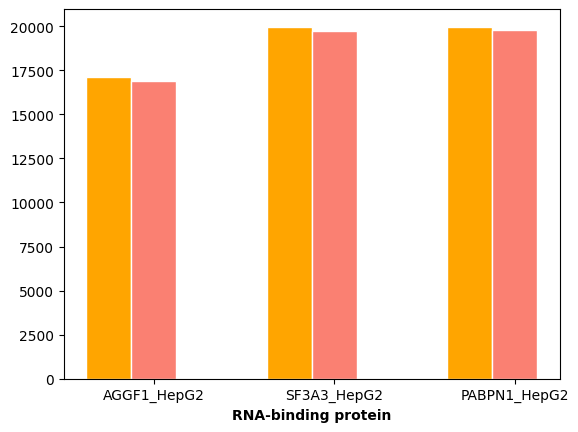

In [32]:
#make sure to change the code a bit 
barWidth = 0.25 

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')
        

        
#set heights of bars
bars1 = plot_ds['original length']
bars2 = plot_ds['modified length']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 
# Make the plot
plt.bar(r1, bars1, color='#FFA500', width=barWidth, edgecolor='white', label='original length')#maybe filtered and unfiltered
plt.bar(r2, bars2, color='#FA8072', width=barWidth, edgecolor='white', label='modified length')

 
# Add xticks on the middle of the group bars
plt.xlabel('RNA-binding protein', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], plot_ds['RBP'])
addlabels(r1, bars2)

# Create legend & Show graphic
plt.legend()
plt.show()




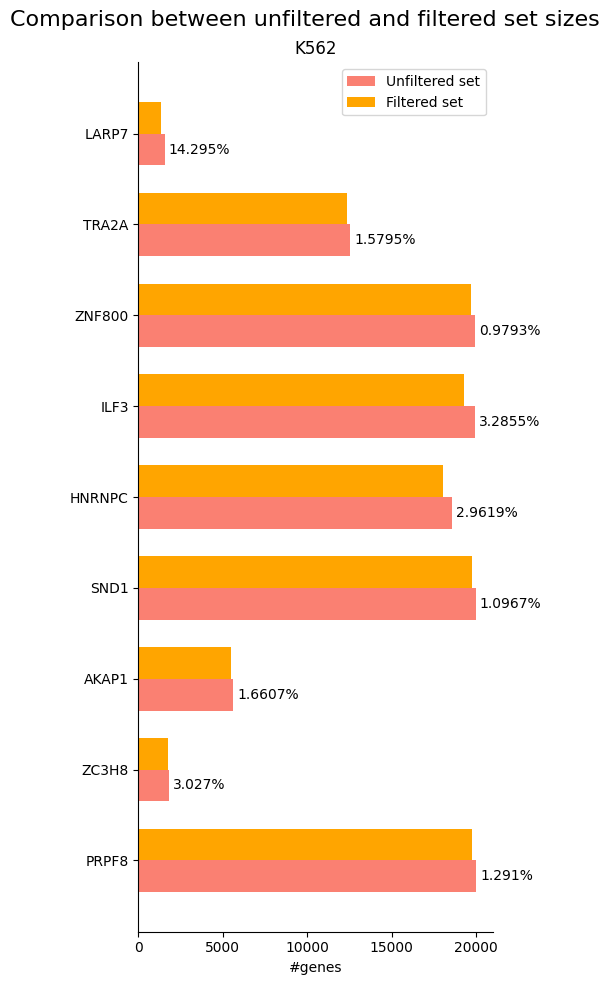

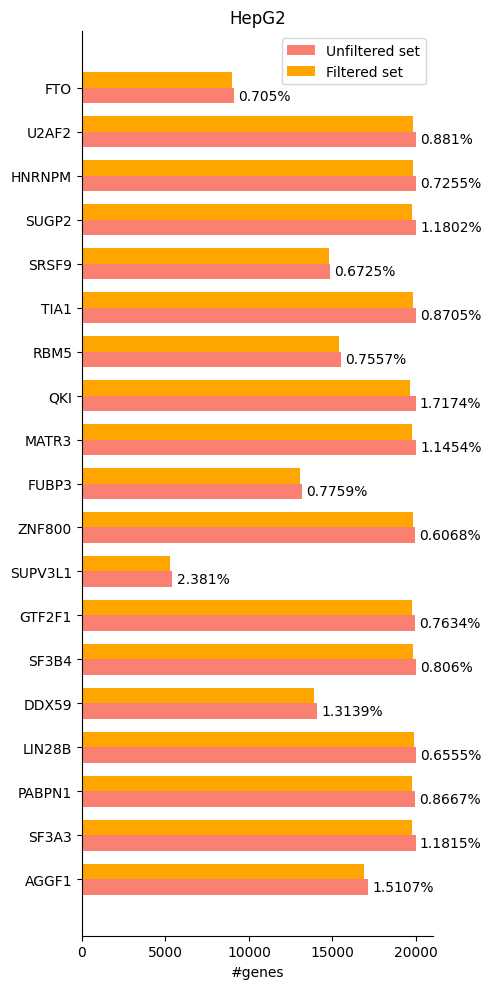

In [92]:
import matplotlib.pyplot as plt
import numpy as np
#from brokenaxes import brokenaxes
 
plot_ds['percentage'] = 100- ((plot_ds['modified length']/plot_ds['original length'] )* 100 )
plot_ds['percentage'] = plot_ds['percentage'].map(lambda x : float("{:.4f}".format(x)))
plot_ds['percentage'] = plot_ds['percentage'].map(lambda x : str(x) + '%') 

plot_ds_Hep = plot_ds[plot_ds.RBP.map(lambda x : "HepG2" in x)]
plot_ds_K562 = plot_ds[plot_ds.RBP.map(lambda x : "K562" in x)]

#K562
labelsK = plot_ds_K562['RBP'].str.split('_').str[0]#removed the cell line because I'm going to do two plots
bar1K = plot_ds_K562['original length']
bar2K = plot_ds_K562['modified length']
percentageK = plot_ds_K562['percentage']

xK = np.arange(len(labelsK))  # the label locations
width = 0.35  # the width of the bars

#fig, (ax, axK)  = plt.subplots(1,2)
figK, axK = plt.subplots(figsize=(5, 10))
rects1K = axK.barh(xK - width/2, bar1K, width, color='#FA8072', label='Unfiltered set')
rects2K = axK.barh(xK + width/2, bar2K, width, color='#FFA500', label='Filtered set')

# Add some text for labels, title and custom x-axis tick labels, etc.
axK.set_xlabel('#genes')
axK.set_title('K562') #here introduce a new plot in the same figure to divide cell lines
axK.set_yticks(xK, labelsK)
axK.legend()

axK.bar_label(rects1K, labels = percentageK, padding=3)
#axK.bar_label(rects2K, labels = None, padding=3)

axK.spines[['top', 'right']].set_visible(False)

#Hep
labels = plot_ds_Hep['RBP'].str.split('_').str[0]#removed the cell line because I'm going to do two plots
bar1 = plot_ds_Hep['original length']
bar2 = plot_ds_Hep['modified length']
percentage = plot_ds_Hep['percentage']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(5, 10))
rects1 = ax.barh(x - width/2, bar1, width, color='#FA8072', label='Unfiltered set')
rects2 = ax.barh(x + width/2, bar2, width, color='#FFA500', label='Filtered set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('#genes')
ax.set_title('HepG2') #here introduce a new plot in the same figure to divide cell lines
ax.set_yticks(x, labels)
ax.legend()

ax.bar_label(rects1,labels = percentage, padding=3)
#ax.bar_label(rects2, labels = None ,padding=3)

ax.spines[['top', 'right']].set_visible(False)

figK.suptitle('Comparison between unfiltered and filtered set sizes', fontsize=16)

fig.tight_layout()

figK.tight_layout()

plt.show()

In [77]:
plot_ds

,original length,modified length,RBP,percentage
0,17144,16885,AGGF1_HepG2,1.510733
0,19974,19738,SF3A3_HepG2,1.181536
0,19960,19787,PABPN1_HepG2,0.866733
0,19985,19854,LIN28B_HepG2,0.655492
0,19985,19727,PRPF8_K562,1.290968
0,14080,13895,DDX59_HepG2,1.313920
0,19975,19814,SF3B4_HepG2,0.806008
0,1817,1762,ZC3H8_K562,3.026968
0,19912,19760,GTF2F1_HepG2,0.763359
0,5418,5289,SUPV3L1_HepG2,2.380952


In [35]:
len(df_eCLIP)

19965

In [38]:
len(df_eclip_ok)

19847

In [39]:
filter_eCLIP('processed/HNRNPC_HepG2/peaks.crosslink.anno.bed', 'processed/HNRNPC_HepG2/peaks.crosslink.anno.filt.bed' )

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr15,65785125,65785126,HNRNPC_HepG2_rep02,6.690730,-,chr15,65658046,65792293,ENSG00000174485.16|DENND4A|mRNA;ENSG0000023831...,.,-,1
1,chrX,30660835,30660836,HNRNPC_HepG2_rep02,6.499249,+,chrX,30653359,30731462,ENSG00000198814.14|GK|mRNA;ENSG00000229331.1|G...,.,+,1
2,chrX,30660824,30660825,HNRNPC_HepG2_rep02,6.461530,+,chrX,30653359,30731462,ENSG00000198814.14|GK|mRNA;ENSG00000229331.1|G...,.,+,1
3,chr18,9117050,9117051,HNRNPC_HepG2_rep02,6.289214,+,chr18,9102630,9285985,ENSG00000178127.13|NDUFV2|mRNA;ENSG00000265257...,.,+,1
4,chr20,17966389,17966390,HNRNPC_HepG2_rep01,6.246230,-,chr20,17941597,18059188,ENSG00000089006.17|SNX5|mRNA;ENSG00000125850.1...,.,-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19960,chr20,41053145,41053146,HNRNPC_HepG2_rep01,3.016495,+,chr20,41028822,41124487,ENSG00000198900.7|TOP1|mRNA,.,+,1
19961,chr20,25632683,25632684,HNRNPC_HepG2_rep01,3.016495,+,chr20,25624045,25689032,ENSG00000213742.7|ZNF337-AS1|lncRNA;ENSG000002...,.,+,1
19962,chr20,1335565,1335566,HNRNPC_HepG2_rep01,3.016495,+,chr20,1325400,1378735,ENSG00000234684.8|SDCBP2-AS1|lncRNA;ENSG000002...,.,+,1
19963,chr6,57103752,57103753,HNRNPC_HepG2_rep01,3.016495,+,chr6,57086844,57170305,ENSG00000112200.17|ZNF451|mRNA,.,+,1


In [7]:
#apparently, there are no gene ids in this file, right?? - yes, just the range of positions 
df2 = pd.read_csv("C:/Users/sofia/Desktop/THESIS/PROJECT/GSE63753_hek293.abcam.CIMS.m6A.9536.bed.txt", sep='\t', header = None)
df2.head()

,0,1,2,3,4,5,6,7,8
0,chr10,100176311,100176312,B045_1-4_chr10_r_c635[k=4][m=2]_AGACT,2,-,AGACT,4,0.500000
1,chr10,101090591,101090592,B045_1-4_chr10_f_c695[k=4][m=2]_GGACT,2,+,GGACT,4,0.500000
2,chr10,101370996,101370997,B045_1-4_chr10_r_c643[k=4][m=2]_GAACG,2,-,GAACG,4,0.500000
3,chr10,101503020,101503021,B045_1-4_chr10_f_c698[k=4][m=2]_TGACA,2,+,TGACA,4,0.500000
4,chr10,101515460,101515461,B045_1-4_chr10_f_c699[k=11][m=2]_GGACT,2,+,GGACT,11,0.181818
